In [1]:
%matplotlib inline
import xarray as xr
import numpy as np
import pandas as pd

In [2]:
remote_data = xr.open_dataarray('http://tds.hycom.org/thredds/dodsC/GLBu0.08/expt_91.1/uv3z?water_u')
remote_data

<xarray.DataArray 'water_u' (time: 738, depth: 40, lat: 2001, lon: 4500)>
[265812840000 values with dtype=float32]
Dimensions without coordinates: time, depth, lat, lon
Attributes:
    long_name:      Eastward Water Velocity
    standard_name:  eastward_sea_water_velocity
    units:          m/s
    NAVO_code:      17

In [3]:
da = remote_data.isel(depth=0)

In [12]:
# Find region of interest (30.5/-81.5/18/-65.5)
# make psudo lon and lat and coords aren't read in properly
plon = np.linspace(0,360-(360./len(da.lon)),num=len(da.lon))
plat = np.linspace(-80,80,num=len(da.lat))
lonw = np.abs(plon-(360-81.5)).argmin()
lone = np.abs(plon-(360-65.5)).argmin()
latn = np.abs(plat-30.5).argmin()
lats = np.abs(plat-18.).argmin()
latdim = plat[lats:latn]
londim = plon[lonw:lone]
print(lonw, lone, lats, latn)

3481 3681 1225 1381
[18.   18.08 18.16 18.24 18.32 18.4  18.48 18.56 18.64 18.72 18.8  18.88
 18.96 19.04 19.12 19.2  19.28 19.36 19.44 19.52 19.6  19.68 19.76 19.84
 19.92 20.   20.08 20.16 20.24 20.32 20.4  20.48 20.56 20.64 20.72 20.8
 20.88 20.96 21.04 21.12 21.2  21.28 21.36 21.44 21.52 21.6  21.68 21.76
 21.84 21.92 22.   22.08 22.16 22.24 22.32 22.4  22.48 22.56 22.64 22.72
 22.8  22.88 22.96 23.04 23.12 23.2  23.28 23.36 23.44 23.52 23.6  23.68
 23.76 23.84 23.92 24.   24.08 24.16 24.24 24.32 24.4  24.48 24.56 24.64
 24.72 24.8  24.88 24.96 25.04 25.12 25.2  25.28 25.36 25.44 25.52 25.6
 25.68 25.76 25.84 25.92 26.   26.08 26.16 26.24 26.32 26.4  26.48 26.56
 26.64 26.72 26.8  26.88 26.96 27.04 27.12 27.2  27.28 27.36 27.44 27.52
 27.6  27.68 27.76 27.84 27.92 28.   28.08 28.16 28.24 28.32 28.4  28.48
 28.56 28.64 28.72 28.8  28.88 28.96 29.04 29.12 29.2  29.28 29.36 29.44
 29.52 29.6  29.68 29.76 29.84 29.92 30.   30.08 30.16 30.24 30.32 30.4 ]
[278.48 278.56 278.64 278.72 278

In [5]:
da2 = da.isel(lat=slice(lats, latn), lon=slice(lonw, lone))

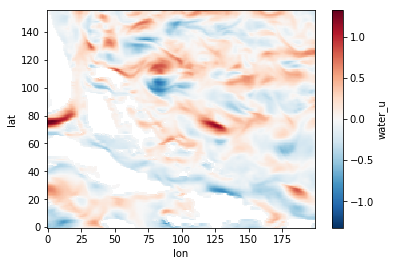

In [6]:
da2.isel(time=0).plot()

In [14]:
# make pseudo time as coords aren't read in
# Daily missing days
# https://hycom.org/faqs/463-nrl-netcdf-outputs-missing-days
missingdays = ['2015-09-19', '2015-03-25', '2015-03-15', '2015-01-02', '2014-04-13']
# First time point is 2014-04-07T00:00:00Z. Last time points is 2016-04-18T00:00:00Z
times = pd.date_range(start='04/07/2014',  end='04/18/2016', freq='D')
# Drop these time values
for i, t in enumerate(missingdays):
    _loc = times.get_loc(missingdays[i])
    times = times.drop(times[_loc])
    
# Select Sep 29th - October 3rd
ts = times.get_loc('2015-09-29')
te = times.get_loc('2015-10-03')+1
timedim = times[ts:te]
print(ts, te)

535 540
DatetimeIndex(['2015-09-29', '2015-09-30', '2015-10-01', '2015-10-02',
               '2015-10-03'],
              dtype='datetime64[ns]', freq=None)


<xarray.DataArray 'water_u' (time: 5, lat: 156, lon: 200)>
[156000 values with dtype=float32]
Dimensions without coordinates: time, lat, lon
Attributes:
    long_name:      Eastward Water Velocity
    standard_name:  eastward_sea_water_velocity
    units:          m/s
    NAVO_code:      17


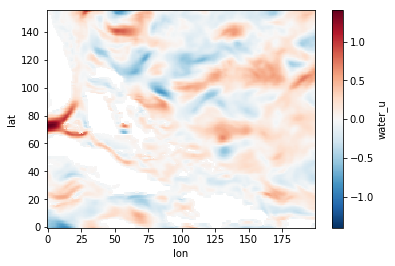

In [19]:
dau = da2.isel(time=slice(ts, te))
dau.isel(time=0).plot()
print(dau)

<xarray.DataArray 'water_v' (time: 5, lat: 156, lon: 200)>
[156000 values with dtype=float32]
Dimensions without coordinates: time, lat, lon
Attributes:
    long_name:      Northward Water Velocity
    standard_name:  northward_sea_water_velocity
    units:          m/s
    NAVO_code:      18


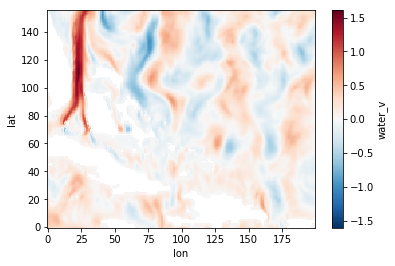

In [20]:
remote_data = xr.open_dataarray('http://tds.hycom.org/thredds/dodsC/GLBu0.08/expt_91.1/uv3z?water_v')
dav = remote_data.isel(depth=0, lat=slice(lats, latn), lon=slice(lonw, lone), time=slice(ts, te))
dav.isel(time=0).plot()
print(dav)

In [27]:
_dau = xr.DataArray(dau.values, coords=[timedim, latdim, londim], dims=['time', 'lat', 'lon'])
_dav = xr.DataArray(dav.values, coords=[timedim, latdim, londim], dims=['time', 'lat', 'lon'])
ds = xr.Dataset({'u': _dau, 'v': _dav})
ds.to_netcdf('HyCOM.nc')
print(ds)

<xarray.Dataset>
Dimensions:  (lat: 156, lon: 200, time: 5)
Coordinates:
  * time     (time) datetime64[ns] 2015-09-29 2015-09-30 2015-10-01 ...
  * lat      (lat) float64 18.0 18.08 18.16 18.24 18.32 18.4 18.48 18.56 ...
  * lon      (lon) float64 278.5 278.6 278.6 278.7 278.8 278.9 279.0 279.0 ...
Data variables:
    u        (time, lat, lon) float32 -0.53000003 -0.55600005 -0.58900005 ...
    v        (time, lat, lon) float32 0.41500002 0.388 0.35000002 0.32500002 ...
